# qGANs for Loading Random Distributions

Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$. 

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

For an example of how to use a trained qGAN in an application, the pricing of financial derivatives, please see the
[Option Pricing with qGANs](https://github.com/Qiskit/qiskit-finance/tree/main/docs/tutorials/10_qgan_option_pricing.ipynb) tutorial.

In [2]:
import numpy as np

seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt

%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

## Load the Training Data

First, we need to load the $k$-dimensional training data samples (here k=1).

Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [3]:
# Number training data samples
number_of_training_sample = 1000

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
n=2
bounds = [0.0, 2**n-1]
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [n]

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=number_of_training_sample)

## Initialize the qGAN

The qGAN consists of a quantum generator $G_{\theta}$, i.e., an ansatz, and a classical discriminator $D_{\phi}$, a neural network.

To implement the quantum generator, we choose a depth-$1$ ansatz that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be $>1$ because higher circuit depths enable the representation of more complex structures.

The classical discriminator used here is based on a neural network implementation using NumPy. There is also a discriminator based on PyTorch which is not installed by default when installing Qiskit - see [Optional Install](https://github.com/Qiskit/qiskit-machine-learning#optional-installs) for more information.

Here, both networks are updated with the ADAM optimization algorithm (ADAM is qGAN optimizer default).

In [4]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 300
# Batch size
batch_size = 100

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)

# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed)

# Set an initial state for the generator circuit as a uniform distribution
# This corresponds to applying Hadamard gates on all qubits
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement='linear', reps=1)

init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/var/folders/26/bfg4nt4s0f17qx8ryxwcpmsw0000gn/T/ipykernel_47295/2395255437.py:15: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


## Run the qGAN Training

During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

Please note that the training, for the purpose of this notebook, has been kept briefer by the selection of a known initial point (`init_params`). Without such prior knowledge be aware training may take some while.

In [12]:
# Run qGAN for "number_of_trial" runs and find the best trial with the minimum relative entropy
result_set = {}
number_of_trial = 20
for trial in range(number_of_trial):
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
    result = qgan.run(quantum_instance)
    result_set[trial] = [result['params_g'], result['rel_entr']]
    print(trial, result['rel_entr'])
    trial += 1
    
minimum_relative_entropy_trial = 0
for trial in range(number_of_trial):
    if(result_set[trial][1] < result_set[minimum_relative_entropy_trial][1]): 
        minimum_relative_entropy_trial = trial

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=result_set[minimum_relative_entropy_trial][0])
result = qgan.run(quantum_instance)

0 0.6142
1 0.3341
2 0.1062
3 0.4351
4 0.0197
5 0.3709
6 0.225
7 0.0437
8 0.5046
9 0.8459
10 0.0666
11 0.113
12 0.5787
13 0.373
14 0.1682
15 1.0028
16 0.5347
17 0.9733
18 0.7722
19 0.5901


In [13]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [ 0.12082932  0.46601793  0.22499035 ... -0.06801695 -0.02779514
  0.00225447]
  params_g : [0.21241807 4.24819938 2.80585594 1.58092484]
  loss_d : 0.6931
  loss_g : [0.6932]
  rel_entr : 0.0171


## Training Progress & Outcome

Now, we plot the evolution of the generator's and the discriminator's loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution.

Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

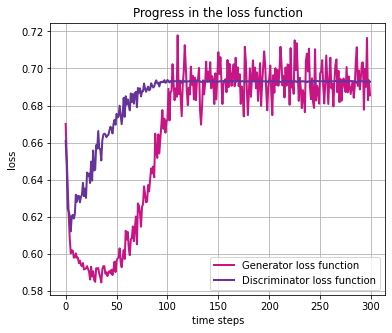

In [14]:
# Plot progress w.r.t the generator's and the discriminator's loss function
initial = num_epochs*minimum_relative_entropy_trial
final = num_epochs*(minimum_relative_entropy_trial+1)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss[initial:final], label="Generator loss function", color="mediumvioletred", linewidth=2)
plt.plot(t_steps, qgan.d_loss[initial:final], label="Discriminator loss function", color="rebeccapurple", linewidth=2)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

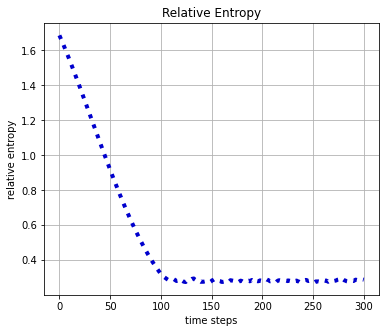

In [15]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr[initial:final])), qgan.rel_entr[initial:final], color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

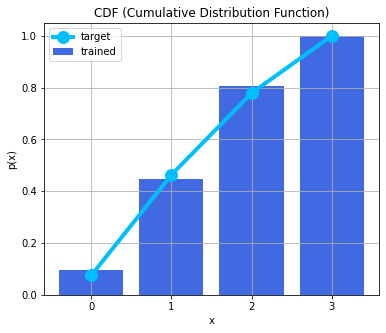

In [16]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='trained')
plt.plot( np.cumsum(log_normal),'-o', label='target', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

<BarContainer object of 4 artists>

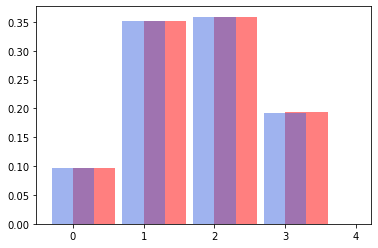

In [17]:
import numpy as np

dist = prob_g
inds=np.random.choice(len(dist), p=dist, size=200000)
sampling = inds

plt.hist(sampling, density=True, alpha=0.5, color='red', width=0.6, label='simulation', bins=[0, 1,2,3,4])
plt.bar(samples_g,  prob_g, color='royalblue', alpha=0.5, width=0.6, label='simulation')

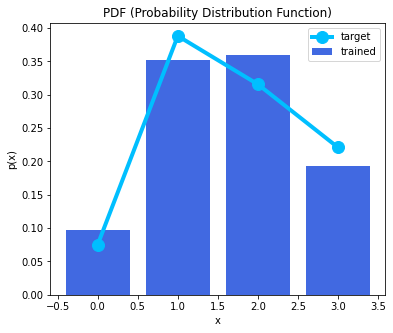

In [18]:
plt.figure(figsize=(6,5))
plt.title('PDF (Probability Distribution Function)')
plt.bar(samples_g,  prob_g, color='royalblue', width=0.8, label='trained')
plt.plot((log_normal), '-o', label='target', color='deepskyblue', linewidth=4, markersize=12)

plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()